# Custom OpenCL kernel execution in clEsperanto

The library clesperanto contains a function `execute` which is the method that is used to execute a kernel code on the GPU. If we look at its signature, it takes the following inputs:
- `anchor`: a reference starting path
- `opencl_kernel_filename`: an OpenCL kernel file which will be loaded
- `kernel_name`: the name of the kernel function to be executed inside the kernel file (usually the same as the filename)
- `global_size`: the working space of the kernel, usually the size of the image to be processed BUT not always
- `parameters`: a `dict` of parameters as `{key, variable}` to be passed to the kernel function

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.data import cells3d
from IPython.display import Markdown
import stackview
cle.select_device('TX')

(OpenCL) NVIDIA GeForce RTX 4070 Laptop GPU (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              560.94
	Device Type:                 GPU
	Compute Units:               36
	Global Memory Size:          8187 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         2046 MB
	Max Clock Frequency:         1230 MHz
	Image Support:               Yes

First we need an example image. Note, this is a 3D image.

In [2]:
image = cells3d()[:,1]
image.shape

(60, 256, 256)

[[ 8868  6923  5690 ... 13942 12804 14653]
 [ 7113  5501  5216 ... 16739 13657 15554]
 [ 5833  7160  5928 ... 15838 16739 17166]
 ...
 [ 2513  3936  3414 ...  3699  4126  4220]
 [ 3319  3272  2513 ...  3699  3367  2940]
 [ 3130  3794  3225 ...  2987  3746  4315]]
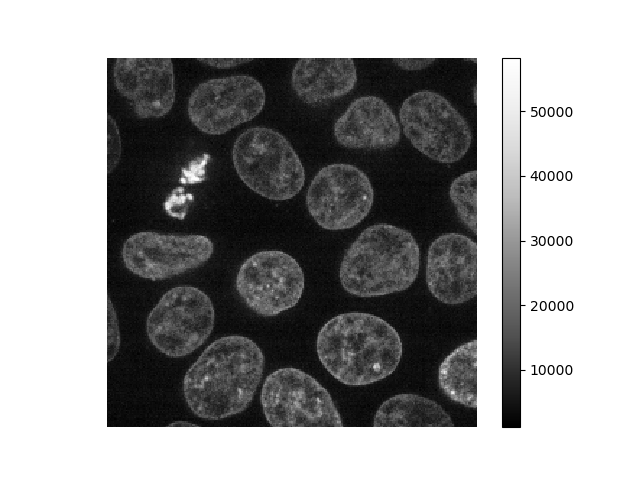
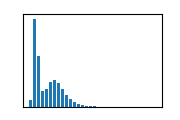

In [3]:
stackview.insight(image[30])

## Custom OpenCL code
The custom OpenCL kernel code we plan to execute is stored in a text-file in the same folder.

In [4]:
opencl_filename = "maximum_z_projection.cl"

with open(opencl_filename, 'r') as file:
    opencl_file_content = file.read()

opencl_file_content = f"""
```c
{opencl_file_content}
´´´
"""
    
display(Markdown(opencl_file_content))


```c
// the sample define the GPU behaviour when accessing pixels outside of the image
__constant sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP_TO_EDGE | CLK_FILTER_NEAREST;

// the kernel function itself, with the parameters
__kernel void maximum_z_projection(
    IMAGE_src_TYPE  src,            // the input image, named 'src' 
    IMAGE_dst_TYPE  dst             // the output image, named 'dst'
) 
{
  const int x = get_global_id(0);  // the x coordinate of the current pixel, provided by the GPU thread
  const int y = get_global_id(1);  // the y coordinate of the current pixel, provided by the GPU thread

  IMAGE_src_PIXEL_TYPE max = 0;
  for (int z = 0; z < GET_IMAGE_DEPTH(src); ++z)  // loop over all z-axis range of the image
  {
    // read the pixel value at the current position (x,y,z) from the input image 'src'
    const IMAGE_src_PIXEL_TYPE value = READ_IMAGE(src, sampler, POS_src_INSTANCE(x,y,z,0)).x;  
    if (value > max || z == 0) {  // conditional statement to find the maximum value
      max = value;
    }
  }

  // write the pixel value at the current position (x,y,z) of the output image 'dst'
  WRITE_IMAGE(dst, POS_dst_INSTANCE(x,y,0,0), CONVERT_dst_PIXEL_TYPE(max));
}
´´´


## Kernel configuration
Before processing the image on the GPU, we need to reserve memory in the GPU and send the input image there. We also need to setup a dictionary with ´parameters´ that will be sent to the kernel. The working range defines how many operations the GPU is supposed to do. In our case, we plan to compute a projection image, which is a 2D version of our 3D dataset. Hence, we specify the output image's width and height as working range.

In [5]:
# Prepare the input and output memory
input_arg = cle.asarray(image)
output_arg = cle.create(input_arg.shape[1:]) # the z dimension is 1 because we will project into 2D along the z axis
output_arg.shape

(256, 256)

In [6]:
# build the dictionary of parameters of the kernel
parameters = {'src': input_arg, 
              'dst': output_arg}

# define the path and name of the kernel file to run
opencl_kernel_filename = 'maximum_z_projection.cl' # the name of the file
kernel_name = 'maximum_z_projection'               # the name of the kernel function in the kernel file

# define the working range of the GPU
working_range = output_arg.shape

Let's run the `execute` method now

In [7]:
cle.execute("__file__", opencl_filename, kernel_name, working_range, parameters)

Notice that we do not return an output image. Here the GPU reads the input `src` and saves the results in the `dst` data, which correspond to our `output_arg` variable.

All we have to do to read it now is to pull it back to CPU memory:

In [8]:
projected = np.asarray(output_arg)
projected.shape

(256, 256)

Note that this is a 2D image now.

[[16787. 16265. 13278. ... 15933. 16170. 15459.]
 [18684. 15554. 13515. ... 16739. 15601. 17640.]
 [13847. 15838. 13135. ... 17308. 16739. 17166.]
 ...
 [ 5833.  4505.  4932. ...  6876.  6259.  6070.]
 [ 4505.  4647.  5264. ...  5548.  6117.  6307.]
 [ 4932.  5169.  4837. ...  6117.  6781.  7492.]]
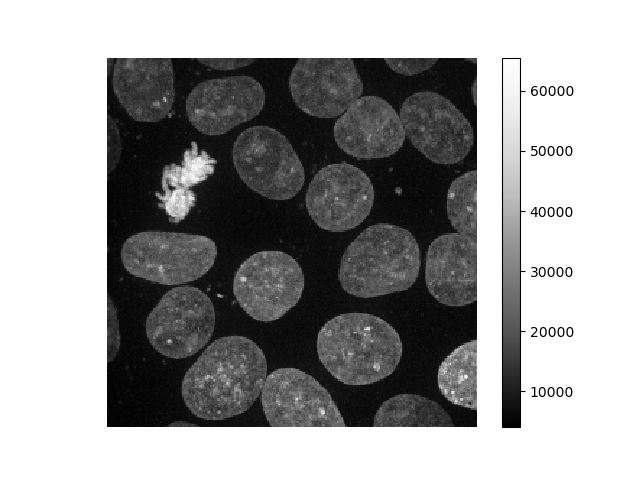
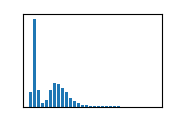

In [9]:
stackview.insight(projected)

## Sanity check
Last step, let's check that what we did is actually correct, by comparing it to the same process but on the CPU.

In [10]:
cpu_projected = image.max(axis=0)

np.array_equal(projected, cpu_projected)

True